## Convolutional Neural Networks, and Large Scale Visual Recognition Project (20 pts)
<em>University of Virginia - Introduction to Computer Vision - Spring 2018 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this project assignment we will apply our knowledge of machine learning and visual recognition using convolutional neural networks to detect various kinds of things from images. We will start from our already familiar CIFAR-10 dataset and we will end up building a more open-ended application.

### 1. Pytorch on the GPU (2pts)
In this section we will experiment with GPU computations and how they speed up some computations under certain conditions.

#### 1.1 Pytorch Installation and GPU Environment Setup (0pts)
We will need to install again pytorch but this time make sure you connect to a GPU enabled machine because a convolutional neural network is very slow on a CPU. Pytorch supports GPU computations for free by using the .cuda() method for tensors and modules. You need to do Runtime -> Change Runtime Type before you run the code below to make sure you are using a machine from Google Cloud that has GPU. Feel free to use your own machine if you have a CUDA-enabled device installed locally.

In [0]:
# Make sure you are using a GPU machine before running this installation!
# You can do this by going to Runtime -> Change runtime type in Google Colab.
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install http://www.cs.virginia.edu/~vicente/vision/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install --no-cache-dir -I pillow
!pip3 install tqdm
# Important! You might need to go to Runtime->Restart Runtime after 
# executing this cell so that things are setup properly.
# Also PLEASE delete the output of this cell, do not include it in the 
# assignment. Thanks!

#### 1.2 GPU Environment Testing (2pts)
Now we are going to test the GPU environment in a task of multiplying two square matrices of size $d\times d$. We provide code below sample code and output for this part but you need to complete the test below.

In [0]:
import torch
import time

# Let's create two matrices of size 4x4 and full of ones.
d = 300
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a dot product between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a dot product between the two matrices in GPU.
start_time = time.time()
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 0.002424s
GPU-time 0.001444s

CPU was 1.68x times the GPU time


Produce a plot using matplotlib that shows the execution time (y-axis) versus the size $d$ of the square matrices (x-axis) for both GPU and CPU (use values of $d$ = [10, 100, 1000, 5000, 10000]). Answer the following question: For what values of $d$ would you recommend using a GPU?

CPU-time 0.000043s
GPU-time 0.000244s

CPU-time 0.000085s
GPU-time 0.000264s

CPU-time 0.027246s
GPU-time 0.001614s

CPU-time 3.229308s
GPU-time 0.031471s

CPU-time 25.663891s
GPU-time 0.120819s



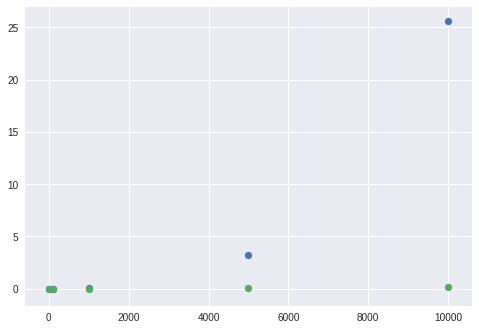

In [0]:
# Your plotting code goes here.
import matplotlib.pyplot as plt

d_list = [10,100,1000, 5000, 10000]
y_cpu = []
y_gpu = []

for d in d_list:
  a = torch.rand(d, d)
  b = torch.rand(d, d)
  
  start_time = time.time()
  output = torch.mm(a,b)  # Regular multiplication in CPU.
  cpu_time = time.time() - start_time
  y_cpu.append(cpu_time)
  print('CPU-time {0:.6f}s'.format(cpu_time))
  
  start_time = time.time()
  a = a.cuda() # Move to GPU.
  b = b.cuda() # Move to GPU.
  output = torch.mm(a,b)  # Multiplication happens in GPU.
  gpu_time = time.time() - start_time
  y_gpu.append(gpu_time)
  print('GPU-time {0:.6f}s\n'.format(gpu_time))

plt.figure()
plt.scatter(d_list, y_cpu)
plt.scatter(d_list, y_gpu)
plt.show()

Answer: The graph shows that the performance of CPU is better than GPU when d is less than 100. I further tested the d value and discovered that the CPU and GPU achieve similar performance when d is equal to 250. Therefore, I would recommend using GPU for d value greater than 250

**Final Comments:** In the GPU code there is a more or less fixed cost of moving tensors to the GPU, this causes using GPUs slower for small tensors counter-productive. Try timing this separately and estimate the cost of this move. Most functions in pytorch have a CUDA implementation so just by moving tensors to the GPU using .cuda() you can perform any operation in a highly parallel manner on a GPU. Moreover, Pytorch supports parallelization on multiple GPUs as well.<br/><br/>

### 2. Convolutional Neural Networks (CIFAR-10 Dataset) (4pts)
This section will build on the previous project but now we will use a convolutional neural network to obtain higher accuracies.

#### 2.1 CIFAR-10 Data Loading (0pts). 
In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects. First, let's download a local copy from the CS server.

In [0]:
import torchvision
from torchvision import datasets

!wget -nc https://www.cs.virginia.edu/~vicente/vision/cifar-10-python.tar.gz -P datalab
!tar xf datalab/cifar-10-python.tar.gz -C datalab
# Please delete the output generated by this cell.

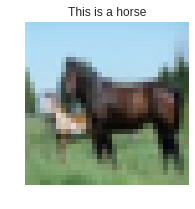

In [2]:
import matplotlib.pyplot as plt

# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
train_data = datasets.CIFAR10('./datalab', train = True)

# This samples the 12-th image from the dataset.
# Try changing the index below to see different images in the dataset.
image, category = train_data[12]

# Display the image and its label.
plt.figure(figsize=(3,3))
plt.title('This is a %s' % categories[category])
plt.imshow(image); plt.grid('off');plt.axis('off')
plt.show()

#### 2.3 Convolutional Neural Network classifier (2pts)
In this section, you will define a convolutional neural network classifier and compute the accuracy of the model on CIFAR-10. Feel free to create any network that you consider would work well. You can get inspiration in some of the convolutional neural network architectures studied in class. I recommend you start with the LeNet architecture included below and start from there.

In [0]:
# Defining the model.
from tqdm import tqdm as tqdm
import torch
import torch.nn as nn
import torch.optim as optim

learningRate = 1e-2  # Single learning rate for this lab.

# LeNet is French for The Network, and is taken from Yann Lecun's 1998 paper
# on digit classification http://yann.lecun.com/exdb/lenet/
# This was also a network with just two convolutional layers.
class JeffNet(nn.Module):
    def __init__(self):
        super(JeffNet, self).__init__()
        
        # Convolutional layers.
        self.conv1 = ConvLayer(3,64, kernel_size=3)
        self.conv2 = ConvLayer(64,64, kernel_size=3, max_pool=True)
        
        self.conv3 = ConvLayer(64,128, kernel_size=3)
        self.conv4 = ConvLayer(128,128, kernel_size=3, max_pool=True)
        
        self.conv5 = ConvLayer(128,256, kernel_size=3)
        self.conv6 = ConvLayer(256,256, kernel_size=3, max_pool=True)
        
        self.conv7 = ConvLayer(256,256, kernel_size=3)
        self.conv8 = ConvLayer(256,256, kernel_size=3, max_pool=True)
        
        
        """
        self.conv9 = ConvLayer(256,256, kernel_size=3, max_pool=True)
        self.conv10 = ConvLayer(512,512, kernel_size=3)
        self.conv11 = ConvLayer(512,512, kernel_size=3)
        self.conv12 = ConvLayer(512,512, kernel_size=3, max_pool=True)
        """
        
        # Linear layers.
        self.fc1 = nn.Linear(256*2*2, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = out.view(out.size()[0], -1)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

class ConvLayer(nn.Module):
  def __init__(self, 
               in_channel, 
               out_channel, 
               kernel_size, 
               stride=1,
               max_pool=False):
    
    super(ConvLayer, self).__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride)
    self.bn = nn.BatchNorm2d(out_channel)
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    self.padding = nn.ReflectionPad2d(kernel_size // 2)
    
    self.do_max_pool = max_pool
  
  def forward(self, x):
      out = self.padding(x)
      out = F.relu(self.conv(out))
      out = self.bn(out)
      if self.do_max_pool: 
        out = self.maxpool(out);
      return out
      
        
# Definition of our network.
classifier = JeffNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
# This optimizer has access to all the parameters in the model.
#
# It can zero all the parameters by doing:
#                                  optimizer.zero_grad()
#
# It can perform an SGD optimization update step in the direction of
# the gradients for each parameters by doing:
#                                  optimizer.step()
#
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)

#### 2.4 Training the CNN model (2pts)
Train your proposed CNN model and compute the accuracy. Plot the loss for training and validation as training progresses (same as in previous assignment), and the accuracy for training and validation (same as in previous assignment). What is the final accuracy? Hints: Remember to use classifier.train() classifier.eval(), also remember to normalize the input data.

In [4]:
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = T.Compose([
      T.ToTensor(),
      normalize
])

train_losses = []
val_losses = []
train_acc = []
val_acc = []

def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10, batch_size=64):
  use_cuda = torch.cuda.is_available()
  dtype = torch.cuda.LongTensor if use_cuda else torch.LongTensor
  
  for epoch in range(n_epochs):
    print('Epoch ' + str(epoch+1))
    running_loss = 0.0
    correct = 0
    classifier.train()
    for i, (x,label) in enumerate(trainLoader):
      x = Variable(x)
      label = Variable(label)
      
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
        classifier = classifier.cuda()
      
      y = classifier(x)
      
      optimizer.zero_grad()
      loss = criterion(y, label)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.data[0]
      _, max_labels = y.data.max(1)
      correct += (max_labels == label.data).sum()
      
      
    total = batch_size * len(trainLoader)
    train_acc.append(correct / total)
    train_losses.append(running_loss / total)
    print("Training Accuracy: " + str(correct / total))
    print("Train Losses: " + str(running_loss / total))
    
    running_loss = 0.0
    correct = 0
    for i, (x,label) in enumerate(valLoader):
      x = Variable(x, requires_grad=False)
      label = Variable(label, requires_grad=False)
      
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
        classifier = classifier.cuda()
      
      y = classifier(x)
      loss = criterion(y, label)
      running_loss += loss.data[0]
      
      _, max_labels = y.data.max(1)
      correct += (max_labels == label.data).sum()
    
    total = batch_size * len(valLoader)
    val_acc.append(correct / total)
    val_losses.append(running_loss / total)
    print("Validation Accuracy: " + str(correct / total))
    print("Validation Losses: " + str(running_loss / total))

# Call  your training function and 
batch_size = 64

train_data = datasets.CIFAR10(root='./datalab', train = True, transform = preprocess)
validation_data = datasets.CIFAR10(root='./datalab', train = False, transform = preprocess)

trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)

train_model(classifier, criterion, optimizer, 
            trainLoader, valLoader, n_epochs = 10)

Epoch 1
Training Accuracy: 0.5725503516624041
Train Losses: 0.018637505939940128
Validation Accuracy: 0.6474920382165605
Validation Losses: 0.015466241593098944
Epoch 2
Training Accuracy: 0.7374920076726342
Train Losses: 0.011746805004032372
Validation Accuracy: 0.6658041401273885
Validation Losses: 0.015021890745895683
Epoch 3
Training Accuracy: 0.8000719309462916
Train Losses: 0.008939001557972196
Validation Accuracy: 0.6997412420382165
Validation Losses: 0.014016764087210984
Epoch 4
Training Accuracy: 0.8427509590792839
Train Losses: 0.0069633251978465545
Validation Accuracy: 0.7741839171974523
Validation Losses: 0.01006500163726556
Epoch 5
Training Accuracy: 0.8794157608695652
Train Losses: 0.005322445301598657
Validation Accuracy: 0.7466162420382165
Validation Losses: 0.01269032201688191
Epoch 6
Training Accuracy: 0.9094269501278772
Train Losses: 0.004037117122409299
Validation Accuracy: 0.7538813694267515
Validation Losses: 0.012695450753946402
Epoch 7
Training Accuracy: 0.936161

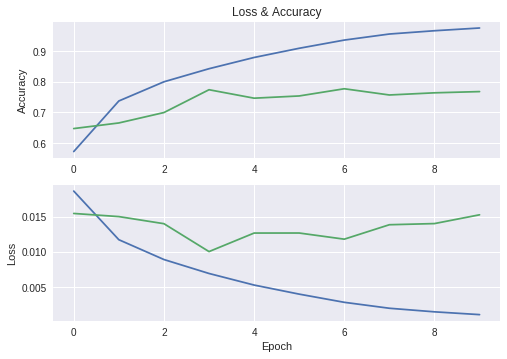

In [5]:
import numpy as np
x = np.arange(10)
y1 = train_losses
y2 = val_losses

plt.subplot(2,1,1)
plt.plot(x, train_acc)
plt.plot(x, val_acc)
plt.title('Loss & Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2,1,2)
plt.plot(x, train_losses)
plt.plot(x, val_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

**Final Comments:** You should get a much better classification accuracy of this model. Try running it in some validation images and see how much better are the predictions of this model compared to the one used in a previous assignment.

### 3. Convolutional Neural Networks (COCO Dataset) (8pts)
In this section we will use a state-of-the-art deep neural network trained on the ILSVRC (Imagenet Large Scale Visual Recognition Challenge) dataset, and "fine-tune" the weights of this network to learn a network that can detect the 80 objects in the COCO Dataset.

#### 3.1 Pre-trained ResNet-50 CNN (0pts)
In this section we will experiment with a ResNet network with 50 layers of depth as seen during class. This network was trained in the ILSVRC task where it was trained on a million images each with one label belonging to 1000 possible classes. First let's load the pre-trained model and categories vocabulary.

In [0]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
resnet = models.resnet50(pretrained = True);
resnet.eval();  # Set in evaluation mode! In this case it matters.

Now let's run an image through the network. Pay careful attention to all the steps.

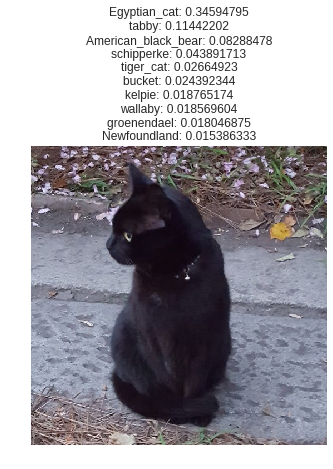

In [0]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}


# 3. Read image from URL into a PIL image type.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  torch.autograd.Variable(preprocessFn(img_pil).unsqueeze(0))
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

#### 3.2 Experiment with ResNet (2pts)
Take pictures of two objects for which the ResNet network works really well and show the predictions, do the same for two objects for which the network doesn't do well. Take your own pictures of objects at your place, don't download images from the internet.

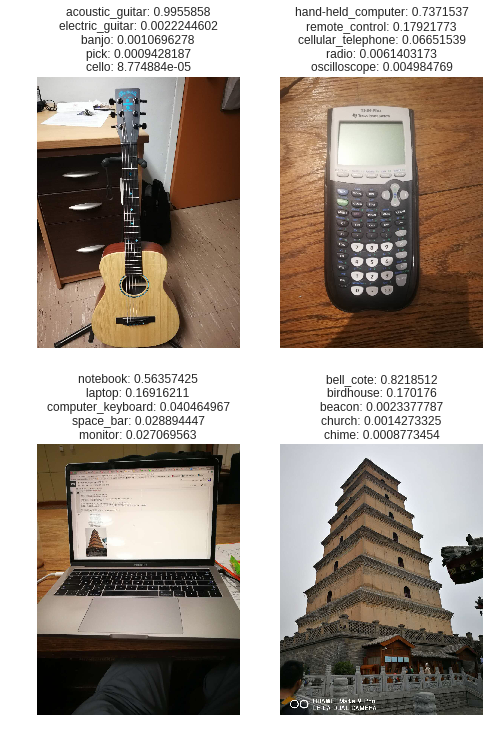

In [0]:
# Your code goes here.
"""
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""

img1 = uploaded['guitar.jpeg']
img4 = uploaded['tower.jpeg']
img3 = uploaded['laptop.jpeg']
img2 = uploaded['calculator.jpeg']

img1 = Image.open(io.BytesIO(img1))
img2 = Image.open(io.BytesIO(img2))
img3 = Image.open(io.BytesIO(img3))
img4 = Image.open(io.BytesIO(img4))


imgs = [img1, img2, img3, img4]

for i in range(4):
  inputVar =  torch.autograd.Variable(preprocessFn(imgs[i]).unsqueeze(0))
  predictions = resnet(inputVar)
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  probs = (-probs).numpy()[0][:5]; indices = indices.numpy()[0][:5]
  preds = ([imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)])
  
  plt.subplot(2,2,i+1)
  plt.title('\n'.join(preds));
  plt.imshow(imgs[i]);
  plt.grid('off'); plt.axis('off');

plt.subplots_adjust(left=None, bottom=0, right=None, top=1.7,
                wspace=None, hspace=None)

The above two are the objects that is categorized correctly. And the bottom two are the objects that the network doesn't do well. （The bottom right one is a Chinese pagoda, although it makes sense for it to be categorized as a bell cote）

#### 3.3 Fine-tuning ResNet to the COCO-Dataset 80-category dataset (6pts)
The COCO (Common Objects in Context) Dataset has 80 object categories. You can browse it here http://cocodataset.org/#home. This dataset also has bounding box annotations but we will not use them in this project. You will only map each image to an 80-dimensional vector where each entry corresponds to an object type, where the value is 1 if the object-type is present and 0 otherwise. (i.e. will not use box annotations, or not use the number of objects of each type). **Hints:** (1) To build the dataloader for COCO you can reuse the dataloder in pytorch for COCO but you need to modify it to return an 80-dimensional vector as label http://pytorch.org/docs/master/torchvision/datasets.html#coco (2) The 80-category prediction will require a different loss since these labels are not mutually exclusive, you will have to use torch.nn.BCEWithLogitsLoss. **Note:** For speed and in order to reduce network overhead use only 20,000 images for training, and 1,000 images for validation.

In [0]:
# Download COCO-Dataset.
!pip3 install http://www.cs.virginia.edu/~vicente/vision/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install --no-cache-dir -I pillow
!pip3 install tqdm
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip
!pip3 install cython
!pip3 install pycocotools

In [2]:
# Your code goes here.
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader, sampler
from pycocotools.coco import COCO

preprocess = transforms.Compose([
     transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])
])

annFile = './annotations/instances_val2014.json'
coco = COCO(annFile)
ids = coco.getCatIds()
id_map = {}
for i,id in enumerate(ids):
  id_map[id] = i


#extract category ids from each target and create an one-hot encoding of size 80
def target_transform(target):
  categories = [entry['category_id'] for entry in target]
  target = torch.zeros(80)
  for cat in categories:
    target[id_map[cat]] = 1
  return target

CocoDataset = datasets.CocoDetection(root='./val2014', annFile=annFile, transform=preprocess, target_transform=target_transform)

trainSampler = sampler.SubsetRandomSampler(indices=np.arange(0,40000,2))
valSampler = sampler.SubsetRandomSampler(indices=np.arange(1,1001,2))

trainLoader = DataLoader(CocoDataset, batch_size=64, shuffle=False, sampler=trainSampler)
valLoader = DataLoader(CocoDataset, batch_size=64, shuffle=False, sampler=valSampler)
    
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(2048, 80)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(resnet.parameters(), lr = 1e-3)

loading annotations into memory...
Done (t=6.24s)
creating index...
index created!
loading annotations into memory...
Done (t=6.69s)
creating index...
index created!


In [3]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 4, batch_size=64):
  use_cuda = torch.cuda.is_available()
  dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
  
  for epoch in range(n_epochs):
    print('Epoch ' + str(epoch+1))
    
    running_loss = 0.0
    correct = 0
    classifier.train()
    for i, (x,label) in enumerate(trainLoader):
      #if i % 150 == 0: print("Iteration " + str(i))
      x = Variable(x, requires_grad=True)
      label = Variable(label)
      
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
        classifier = classifier.cuda()
      
      y = classifier(x)
      
      optimizer.zero_grad()
      loss = criterion(y, label)
      loss.backward()
      optimizer.step()
    
      running_loss += loss.data.cpu()[0]
      
      max_labels = y.data.cpu().numpy().argmax(1)
      correct += (label[np.arange(len(max_labels)), max_labels] == 1).data.cpu().sum()
    
    total = batch_size * len(trainLoader)
    train_acc.append(correct / total)
    train_losses.append(running_loss / total)
    print("Training Accuracy: " + str(correct / total))
    print("Train Losses: " + str(running_loss / total))
    
    
    running_loss = 0.0
    correct = 0
    for i, (x,label) in enumerate(valLoader):
      x = Variable(x, requires_grad=False)
      label = Variable(label, requires_grad=False)
      
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
        classifier = classifier.cuda()
      
      y = classifier(x)
      loss = criterion(y, label)
      running_loss += loss.data.cpu()[0]
      
      max_labels = y.data.cpu().numpy().argmax(1)
      correct += (label[np.arange(len(max_labels)), max_labels] == 1).data.cpu().sum()
    
    total = batch_size * len(valLoader)
    val_acc.append(correct / total)
    val_losses.append(running_loss / total)
    print("Validation Accuracy: " + str(correct / total))
    print("Validation Losses: " + str(running_loss / total))
    
train_model(resnet,criterion,optimizer, trainLoader, valLoader)

Epoch 1
Training Accuracy: 0.5998402555910544
Train Losses: 0.001698276894271207
Validation Accuracy: 0.64453125
Validation Losses: 0.0014278893650043756
Epoch 2
Training Accuracy: 0.6772663738019169
Train Losses: 0.001434438351241235
Validation Accuracy: 0.671875
Validation Losses: 0.0013206597068347037
Epoch 3
Training Accuracy: 0.7174021565495208
Train Losses: 0.001335121744413512
Validation Accuracy: 0.68359375
Validation Losses: 0.001289240492042154
Epoch 4
Training Accuracy: 0.7522464057507987
Train Losses: 0.0012479564487434234
Validation Accuracy: 0.71875
Validation Losses: 0.0012375957885524258


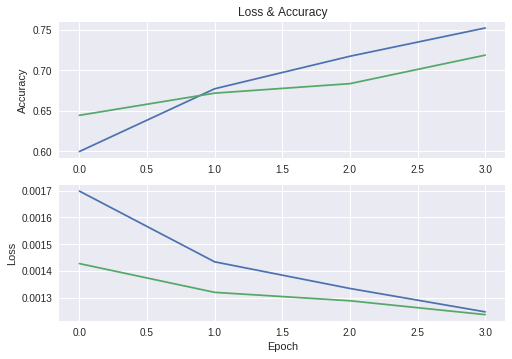

In [6]:
x = np.arange(4)
y1 = train_losses
y2 = val_losses

plt.subplot(2,1,1)
plt.plot(x, train_acc)
plt.plot(x, val_acc)
plt.title('Loss & Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2,1,2)
plt.plot(x, train_losses)
plt.plot(x, val_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Show three example results of your trained model on the validation set of the COCO dataset. More especifically show the top ten predicted categories along with the score for each for three sample images.

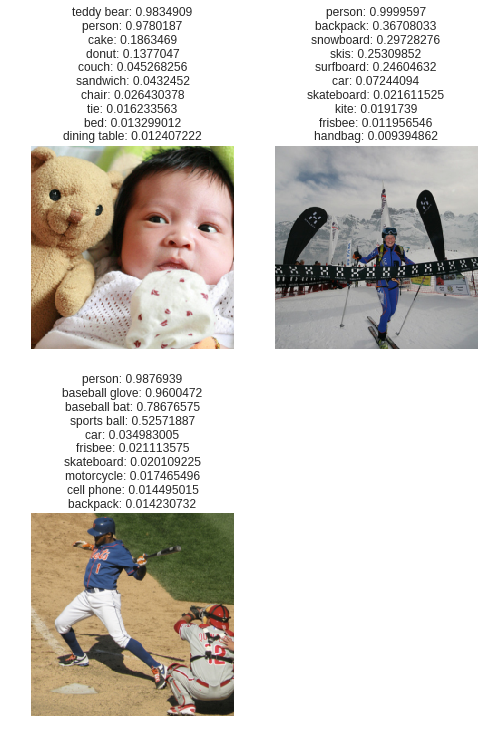

In [4]:
# Your code goes here.
import matplotlib.pyplot as plt
from PIL import Image

def deprocess(img):
    transform = transforms.Compose([
    	transforms.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in (0.229, 0.224, 0.225)]),
    	transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    	transforms.ToPILImage(),
    	])
    return transform(img)
  
resnet.eval()

img1,label = CocoDataset[30]
img2,_ = CocoDataset[2700]
img3,_ = CocoDataset[5000]

imgs = [img1,img2,img3]

id_map_inv = {v: k for k, v in id_map.items()}

for i in range(3):
  inputVar =  torch.autograd.Variable(imgs[i].unsqueeze(0)).cuda()
  predictions = resnet(inputVar)
  scores, indices = (nn.functional.sigmoid(predictions.data.cpu())).sort(descending=True)
  scores = (scores).numpy()[0][:10]
  indices = indices.numpy()[0][:10].astype(int)  
  cat_ids = [id_map_inv[idx] for idx in indices]
  
  preds = [coco.loadCats(id)[0]['name'] + ': ' + str(score) for (score, id) in zip(scores, cat_ids)] 
  
  plt.subplot(2,2,i+1)
  plt.title('\n'.join(preds));
  plt.imshow(deprocess(imgs[i]));
  plt.grid('off'); plt.axis('off');

plt.subplots_adjust(left=None, bottom=0, right=None, top=1.7,
    wspace=None, hspace=None)


**Final Comments:** In this section you learned to use a very deep neural network that was trained to recognize 1000 categories, then you finetuned this network to another dataset that only had 80 categories, and for a different criterion (loss function). How would you measure the accuracy of this model?

### 4. Visual Recognition Open (6pts)
In this section implement any visual recognition application of your choice using data of your own choice. For instance you could train a Convolutional Neural Network on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. The training data has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. You can download the training, validation splits from the following dropbox link: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip). You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots.

In [0]:
# Download and unzip the cats vs dgos dataset.
!pip3 install http://www.cs.virginia.edu/~vicente/vision/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install --no-cache-dir -I pillow
!pip3 install tqdm
!wget -nc https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip
!unzip cats_dogs.zip

In [0]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader, sampler
from PIL import Image


class DogCatDataset(data.Dataset):
  
  def __init__(self, root, transform=None):
    self.samples = self.make_dataset(root)
    self.root = root
    self.transform = transform
    
  def __getitem__(self, index):
    path, label = self.samples[index]
    img = Image.open(path)
    
    if self.transform is not None:
      img = self.transform(img)
    
    return img, label
      
  def __len__(self):
    return len(self.samples)
    
  #return list of tuple (img_path, label)
  def make_dataset(self, root):
    images = []
    for file in os.listdir(root):
      if file.endswith('.jpg'):
        label = file.split('.')[0]
        path = os.path.join(root, file)
        if label == 'cat':
          label = torch.Tensor([1,0])
        elif label == 'dog':
          label = torch.Tensor([0,1])
        images.append((path, label))
    
    return images

preprocess = transforms.Compose([
     transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])
])

In [0]:
trainDataset = DogCatDataset('./trainset', transform=preprocess)
valDataset = DogCatDataset('./valset', transform=preprocess)

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=True)

criterion = nn.BCEWithLogitsLoss()
vgg16 = models.vgg16(pretrained=True)

classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])
classifier.add_module(name='6', module=nn.Linear(4096, 2))
vgg16.classifier = classifier

optimizer = optim.Adam(vgg16.parameters(), lr = 1e-3)

In [3]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 3, batch_size=64):
  use_cuda = torch.cuda.is_available()
  
  for epoch in range(n_epochs):
    print('Epoch ' + str(epoch+1))
    
    running_loss = 0.0
    correct = 0
    classifier.train()
    for i, (x,label) in enumerate(trainLoader):
      x = Variable(x, requires_grad=True)
      label = Variable(label).float()
      
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
        classifier = classifier.cuda()
      
      y = classifier(x)
      
      optimizer.zero_grad()
      loss = criterion(y, label)
      loss.backward()
      optimizer.step()
    
      running_loss += loss.data.cpu()[0]
      
      max_labels = y.data.cpu().numpy().argmax(1)
      correct += (label[np.arange(len(max_labels)), max_labels] == 1).data.cpu().sum()
      
    total = batch_size * len(trainLoader)
    train_acc.append(correct / total)
    train_losses.append(running_loss / total)
    print("Training Accuracy: " + str(correct / total))
    print("Train Losses: " + str(running_loss / total))
    
    running_loss = 0.0
    correct = 0
    for i, (x,label) in enumerate(valLoader):
      x = Variable(x, requires_grad=False)
      label = Variable(label, requires_grad=False).float()
      
      if use_cuda:
        x = x.cuda()
        label = label.cuda()
        classifier = classifier.cuda()
      
      y = classifier(x)
      loss = criterion(y, label)
      running_loss += loss.data.cpu()[0]
      
      max_labels = y.data.cpu().numpy().argmax(1)
      correct += (label[np.arange(len(max_labels)), max_labels] == 1).data.cpu().sum()
    
    total = batch_size * len(valLoader)
    val_acc.append(correct / total)
    val_losses.append(running_loss / total)
    print("Validation Accuracy: " + str(correct / total))
    print("Validation Losses: " + str(running_loss / total))
    
train_model(vgg16,criterion,optimizer, trainLoader, valLoader)

Epoch 1
Training Accuracy: 0.5641473642172524
Train Losses: 0.011293387266631705
Validation Accuracy: 0.6159018987341772
Validation Losses: 0.010379426747183257
Epoch 2
Training Accuracy: 0.7232428115015974
Train Losses: 0.008311514564144154
Validation Accuracy: 0.8128955696202531
Validation Losses: 0.006128234488158663
Epoch 3
Training Accuracy: 0.8253294728434505
Train Losses: 0.0061641129205366385
Validation Accuracy: 0.828125
Validation Losses: 0.005686300756598386


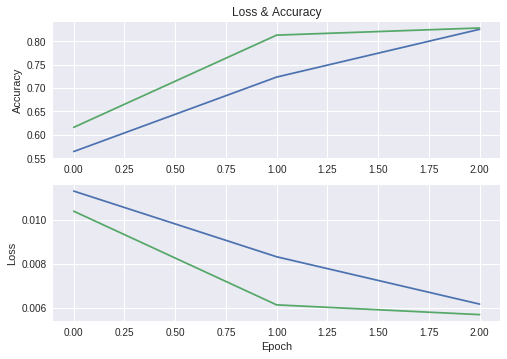

In [5]:
x = np.arange(3)
y1 = train_losses
y2 = val_losses

plt.subplot(2,1,1)
plt.plot(x, train_acc)
plt.plot(x, val_acc)
plt.title('Loss & Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2,1,2)
plt.plot(x, train_losses)
plt.plot(x, val_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

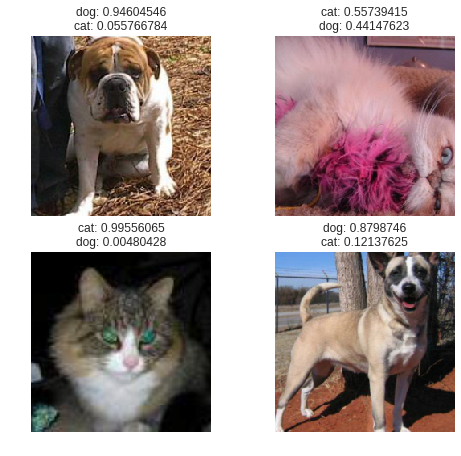

In [4]:
def deprocess(img):
    transform = transforms.Compose([
    	transforms.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in (0.229, 0.224, 0.225)]),
    	transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    	transforms.ToPILImage(),
    	])
    return transform(img)
  
vgg16.eval()

img1,_ = valDataset[0]
img2,_ = valDataset[1000]
img3,_ = valDataset[3000]
img4,_ = valDataset[4000]

imgs = [img1,img2,img3,img4]

def label(id):
  if id == 0:
    return 'cat'
  else:
    return 'dog'

for i in range(4):
  inputVar =  torch.autograd.Variable(imgs[i].unsqueeze(0)).cuda()
  predictions = vgg16(inputVar)
  scores, indices = (nn.functional.sigmoid(predictions.data.cpu())).sort(descending=True)
  scores = (scores).numpy()[0]
  indices = indices.numpy()[0]
  
  preds = [label(id) + ': ' + str(score) for (score, id) in zip(scores, indices)]
  
  plt.subplot(2,2,i+1)
  plt.title('\n'.join(preds));
  plt.imshow(deprocess(imgs[i]));
  plt.grid('off'); plt.axis('off');

plt.subplots_adjust(left=None, bottom=0, right=None, top=1.0,
    wspace=None, hspace=None)

**Final Comments:** If you didn't work in the dogs vs cats dataset, does your task affect people directly? Could your task cause any harm or unfairness to end users of your application? These are questions you should be asking yourself. Finally, I hope you enjoyed the Introduction to Computer Vision class this semester!